In [59]:
import pandas as pd
import numpy as np
import plotly.express as px

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import  Dense, Dropout
import keras_nlp

import tensorflow_text as text
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
data = pd.read_csv("learning-agency-lab-automated-essay-scoring-2/train.csv")

X_train, X_val, y_train, y_val = train_test_split(data['full_text'], data['score'], test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape )

(13845,) (3462,) (13845,) (3462,)


In [3]:
# labels for classifications
y_train = (y_train - 1).to_numpy()
y_val = (y_val - 1).to_numpy()

In [4]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
# Convert to a dictionary with class indices as keys
class_weight_dict = dict(enumerate(class_weights))
# Print the computed class weights (optional)
print(class_weight_dict)

{0: 2.326108870967742, 1: 0.6140234167110165, 2: 0.46011964107676967, 3: 0.7265428211586902, 4: 2.9320203303684877, 5: 19.72222222222222}


In [5]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
# does tokanization, padding and truncation
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_small_en_uncased", trainable=False)
encoder_inputs = preprocessor(text_input)
encoder = keras_nlp.models.BertBackbone.from_preset("bert_small_en_uncased", load_weights=True, trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]  # Shape: [batch_size, 768]

2024-10-16 10:43:07.601187: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-16 10:43:07.601216: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-10-16 10:43:07.601221: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-10-16 10:43:07.601234: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-16 10:43:07.601243: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
for layer in encoder.layers:
    layer.trainable = False

In [7]:
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

In [32]:
l = tf.keras.layers.Dense(128, activation='relu', name='h1')(pooled_output)
l = tf.keras.layers.Dense(64, activation='relu',name='h2')(l)
l = tf.keras.layers.Dense(32, activation='relu', name='h3')(l)
l = tf.keras.layers.Dense(16, activation='relu', name='h4')(l)
l = tf.keras.layers.Dense(6, activation='softmax', name='output')(l)

model=tf.keras.Model(inputs=[text_input], outputs=[l])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy', # from logits
              metrics=['accuracy'])
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_preprocessor   │ [(None, 512),     │          0 │ input_layer[0][0] │
│ (BertPreprocessor)  │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 512),     │ 28,763,648 │ bert_preprocesso… │
│ (BertBackbone)      │ (None, 512, 512)] │            │ bert_preprocesso… │
│                     │                   │            │ bert_preprocesso… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h1 (Dense)          │ (None, 128)       │     65,664 │ bert_backbone[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h2 (Dense)          │ (None, 64)        │      8,256 │ h1[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h3 (Dense)          │ (None, 32)        │      2,080 │ h2[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h4 (Dense)          │ (None, 16)        │        528 │ h3[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │        102 │ h4[0][0]          │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,840,278 (110.02 MB)

 Trainable params: 76,630 (299.34 KB)

 Non-trainable params: 28,763,648 (109.72 MB)

In [33]:
history = model.fit(X_train, y_train, epochs=12, batch_size=32, validation_data=(X_val, y_val)) # , class_weight=class_weight_dict)
model.evaluate(X_val, y_val)
# accuracy: 0.0777 - loss: 1.1673
# accuracy: 0.5426 - loss: 1.0492

Epoch 1/12
433/433 ━━━━━━━━━━━━━━━━━━━━ 236s 534ms/step - accuracy: 0.3719 - loss: 1.4955 - val_accuracy: 0.5090 - val_loss: 1.2376
Epoch 2/12
433/433 ━━━━━━━━━━━━━━━━━━━━ 230s 531ms/step - accuracy: 0.4866 - loss: 1.2385 - val_accuracy: 0.5142 - val_loss: 1.1358
Epoch 3/12
433/433 ━━━━━━━━━━━━━━━━━━━━ 228s 526ms/step - accuracy: 0.5034 - loss: 1.1530 - val_accuracy: 0.5306 - val_loss: 1.0950
Epoch 4/12
433/433 ━━━━━━━━━━━━━━━━━━━━ 226s 522ms/step - accuracy: 0.5173 - loss: 1.1045 - val_accuracy: 0.5352 - val_loss: 1.0896
Epoch 5/12
433/433 ━━━━━━━━━━━━━━━━━━━━ 226s 521ms/step - accuracy: 0.5294 - loss: 1.0892 - val_accuracy: 0.5396 - val_loss: 1.0796
Epoch 6/12
433/433 ━━━━━━━━━━━━━━━━━━━━ 2706s 6s/step - accuracy: 0.5326 - loss: 1.0622 - val_accuracy: 0.5529 - val_loss: 1.0260
Epoch 7/12
433/433 ━━━━━━━━━━━━━━━━━━━━ 227s 525ms/step - accuracy: 0.5392 - loss: 1.0687 - val_accuracy: 0.5557 - val_loss: 1.0200
Epoch 8/12
433/433 ━━━━━━━━━━━━━━━━━━━━ 226s 523ms/step - accuracy: 0.5484 - l

[0.9859011173248291, 0.5699017643928528]

In [28]:
y_val.dtype
y_train.dtype

dtype('int64')

In [49]:
preds_raw = model.predict(X_val) #[:, 0]

109/109 ━━━━━━━━━━━━━━━━━━━━ 38s 353ms/step


In [55]:
preds = preds_raw.argmax(axis=-1)

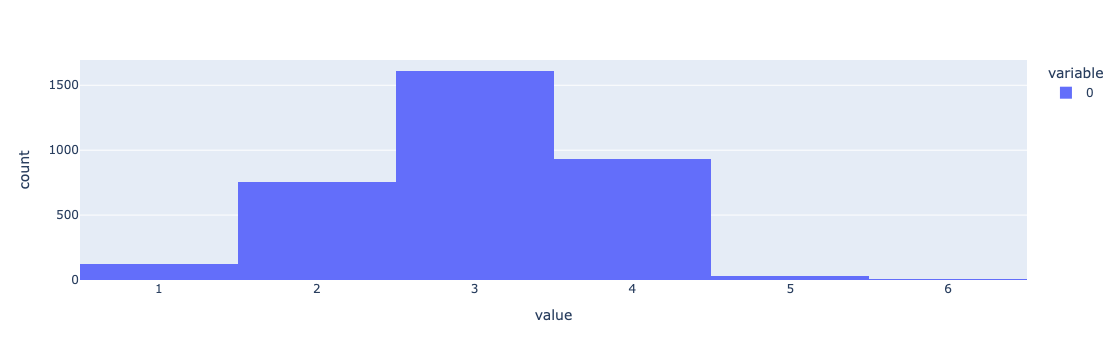

In [57]:
px.histogram(preds+1)

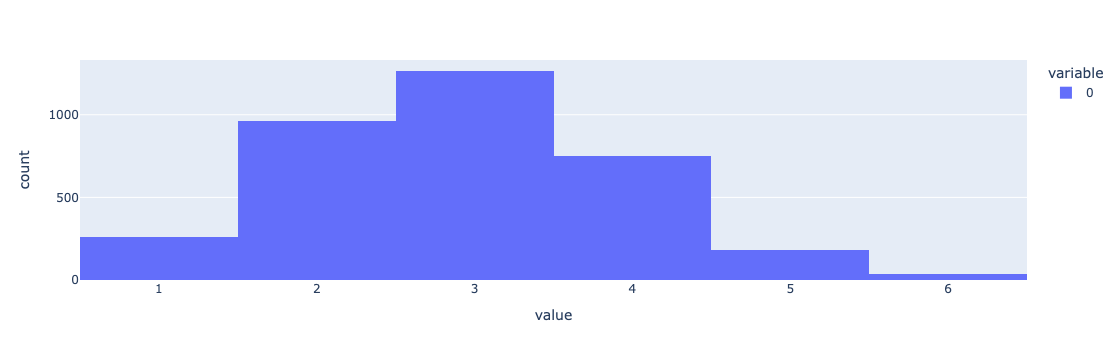

In [14]:
px.histogram(y_val+1)

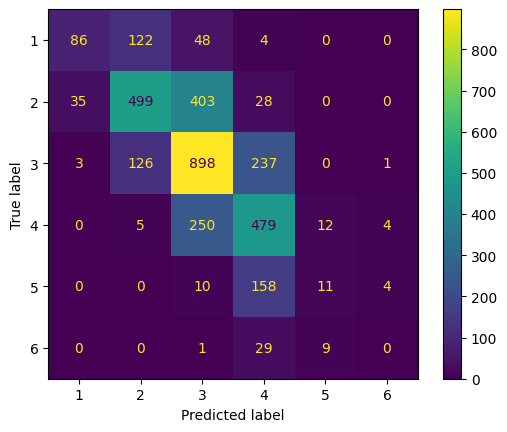

In [64]:
# Plot confusion matrix
cm = confusion_matrix(y_val+1, preds+1, labels=list(set(y_val+1)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(y_val+1)))
disp.plot()

In [15]:
print(np.mean(abs(preds - y_val)))
print(np.mean((np.round(preds, 0) - y_val)**2))

1.91231125951693
4.8272674754477185


In [16]:
print(min(preds), max(preds))

0.00030520812 0.9299879
